# Task 1: Preprocess dataset

In [36]:
import json
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from transformers import BertTokenizer, BertForSequenceClassification, BertConfig, BertModel, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, Dataset, random_split
import torch
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import string
import torch


# File paths
train_file_path = 'data/train.jsonl'
test_file_path = 'data/test.jsonl'

## Naive Bayes preprocess dataset

In [37]:
# Function to load data from jsonl file into a pandas DataFrame
def load_dataNB(file_path):
    data = []
    with open(file_path, 'r') as file:
        for line in file:
            data.append(json.loads(line))
    return pd.DataFrame(data)

# Load training and test data
train_dataNB = load_dataNB(train_file_path)
test_dataNB = load_dataNB(test_file_path)

# Preprocessing: Bag of Words representation using CountVectorizer
vectorizer = CountVectorizer()
X_train_NB = vectorizer.fit_transform(train_dataNB['text'])
y_train_NB = train_dataNB['label']
X_test_NB = vectorizer.transform(test_dataNB['text'])
y_test_NB = test_dataNB['label']


## BERT preprocess

In [38]:
# Function to load data from a JSONL file
def load_data_Bert(file_path):
    data = []
    with open(file_path, 'r') as file:
        for line in file:
            data.append(json.loads(line))
    return data

# Load data from the JSONL files
train_data_Bert = load_data_Bert(train_file_path)
test_data_Bert = load_data_Bert(test_file_path)

# Extract texts and labels for training and testing
X_train_Bert = [entry['text'] for entry in train_data_Bert]
y_train_Bert = [entry['label'] for entry in train_data_Bert]
X_test_Bert = [entry['text'] for entry in test_data_Bert]
y_test_Bert = [entry['label'] for entry in test_data_Bert]

# Load pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bhadresh-savani/bert-base-uncased-emotion')

# Dataset class for handling the text data
class EmotionDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )
        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Create datasets
train_dataset_Bert = EmotionDataset(X_train_Bert, y_train_Bert, tokenizer)
test_dataset_Bert = EmotionDataset(X_test_Bert, y_test_Bert, tokenizer)

# Load pre-trained BERT model for sequence classification
model_Bert = BertForSequenceClassification.from_pretrained('bhadresh-savani/bert-base-uncased-emotion', num_labels=len(set(y_train_Bert)))
# Load BERT model NOT pre-trained on emotion dataset
model_Bert_non = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(set(y_train_Bert)))


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Task 2: Implement Naive Bayes and BERT models

## Naive Bayes

In [39]:
# Naive Bayes implementation
class NaiveBayes:
    def __init__(self):
        self.log_prior = None
        self.log_likelihood = None
        self.classes = None

    def fit(self, X, y):
        # Calculate the prior probabilities and likelihoods for each class
        self.classes = np.unique(y)
        n_classes = len(self.classes)
        n_features = X.shape[1]

        self.log_prior = np.log(np.array([np.sum(y == c) for c in self.classes]) / len(y))

        # Calculate likelihoods
        self.log_likelihood = np.zeros((n_classes, n_features))
        for idx, c in enumerate(self.classes):
            X_c = X[y == c]
            self.log_likelihood[idx, :] = np.log((np.sum(X_c, axis=0) + 1) / (np.sum(X_c) + n_features))

    def predict(self, X):
        # Predict the class for each sample in X
        predictions = []
        for x in X:
            log_prob = self.log_prior + x @ self.log_likelihood.T
            prediction = np.argmax(log_prob)
            predictions.append(self.classes[prediction])
        return np.array(predictions)

    def evaluate_accuracy(self, y_true, y_pred):
        # Calculate the accuracy of the predictions
        return np.mean(y_true == y_pred)




## Pre-trained BERT model
bhadresh-savani/bert-base-uncased-emotion

In [40]:
import datasets
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### BERT model pre-trained on dair-ai/emotion dataset

In [41]:
# Load model pre-trained on dair-ai/emotion dataset and corresponding tokenizer
tokenizer = AutoTokenizer.from_pretrained("bhadresh-savani/bert-base-uncased-emotion")
model = AutoModelForSequenceClassification.from_pretrained("bhadresh-savani/bert-base-uncased-emotion")
model.to(device)


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

### BERT model pre-trained **NOT** specifically on dair-ai/emotion dataset

In [42]:
# Load model pre-trained NOT specifically on dair-ai/emotion dataset
tokenizer_non = AutoTokenizer.from_pretrained("bert-base-uncased", num_labels=6)
model_non = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=6)
model_non.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [43]:
# Load the dataset
dataset = load_dataset("dair-ai/emotion")
dataset = dataset.with_format("torch", device=device)

# Select the test set
test_set = dataset['test']

# Function to encode texts
def encode_texts(tokenizer, texts):
    return tokenizer.batch_encode_plus(
        texts,
        padding=True,
        truncation=True,
        max_length=512,
        return_tensors='pt'
    )

# Encode the test set texts
encoded_inputs = encode_texts(tokenizer, test_set['text'])
encoded_inputs_non = encode_texts(tokenizer_non, test_set['text'])

### Inference with models (pre-trained on emotion dataset and NOT on emotion dataset)

In [44]:
# Move model to evaluation mode
# pre-trained on emotion dataset
model.eval()

# Predicting
with torch.no_grad():
    encoded_inputs = {k: v.to(device) for k, v in encoded_inputs.items()}
    outputs = model(**encoded_inputs)

logits = outputs.logits
predicted_labels = torch.argmax(logits, dim=1)

# NOT on emotion dataset
model_non.eval()
with torch.no_grad():
    encoded_inputs_non = {k: v.to(device) for k, v in encoded_inputs_non.items()}
    outputs_non = model_non(**encoded_inputs_non)

logits_non = outputs_non.logits
predicted_labels_non = torch.argmax(logits_non, dim=1)

### Modified Weights

In [45]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def train_Bert_model(model, train_dataset, test_dataset, epochs=8, batch_size=64):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

    for epoch in range(epochs):
        model.train()
        for batch in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{epochs}"):
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()

    model.eval()
    predictions = []
    actuals = []

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            predictions.extend(torch.argmax(logits, dim=1).tolist())
            actuals.extend(labels.tolist())

    # Calculate metrics
    accuracy = accuracy_score(actuals, predictions)
    precision = precision_score(actuals, predictions, average='macro')
    recall = recall_score(actuals, predictions, average='macro')
    f1 = f1_score(actuals, predictions, average='macro')

    return accuracy, precision, recall, f1, predictions


In [46]:
def train_Bert_model_noProgress(model, train_dataset, test_dataset, epochs=8, batch_size=64):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

    for epoch in range(epochs):
        model.train()
        for batch in train_loader:  # Removed tqdm wrapper
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()

    model.eval()
    predictions = []
    actuals = []

    with torch.no_grad():
        for batch in test_loader:  # Removed tqdm wrapper
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            predictions.extend(torch.argmax(logits, dim=1).tolist())
            actuals.extend(labels.tolist())

    # Calculate metrics
    accuracy = accuracy_score(actuals, predictions)
    precision = precision_score(actuals, predictions, average='macro')
    recall = recall_score(actuals, predictions, average='macro')
    f1 = f1_score(actuals, predictions, average='macro')

    return accuracy, precision, recall, f1, predictions


# Task 3: Run experiments

## 3.1: Compare and report the performance of the Naive Bayes, BERT-based models and modified BERT-based model.

In [47]:
# Create and train the Naive Bayes model
model_NB = NaiveBayes()
model_NB.fit(X_train_NB, y_train_NB)

# Predict on the test set
y_pred_NB = model_NB.predict(X_test_NB)

# Evaluate the model
accuracy_NB = model_NB.evaluate_accuracy(y_test_NB, y_pred_NB)

# Print the accuracy
print(f"Model Accuracy: {accuracy_NB}")

Model Accuracy: 0.7655


### pretrained-BERT

In [48]:
# Convert test set labels to tensor for comparison
# true_labels = torch.tensor(test_set['label'])
true_labels = test_set['label'].clone().detach()

accuracy_Bert_sk = classification_report(true_labels.cpu(), predicted_labels.cpu())
accuracy_Bert_non_sk = classification_report(true_labels.cpu(), predicted_labels_non.cpu())

print(accuracy_Bert_sk)
print(accuracy_Bert_non_sk)

              precision    recall  f1-score   support

           0       0.97      0.96      0.97       581
           1       0.94      0.95      0.95       695
           2       0.84      0.79      0.82       159
           3       0.94      0.91      0.92       275
           4       0.86      0.93      0.90       224
           5       0.76      0.73      0.74        66

    accuracy                           0.93      2000
   macro avg       0.89      0.88      0.88      2000
weighted avg       0.93      0.93      0.93      2000

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       581
           1       0.35      0.17      0.23       695
           2       0.00      0.00      0.00       159
           3       0.00      0.00      0.00       275
           4       0.00      0.00      0.00       224
           5       0.03      0.77      0.06        66

    accuracy                           0.08      2000
   macro avg       0.06

d:\MachineLearning\python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\MachineLearning\python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\MachineLearning\python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Modifed weights (for both BERT models)

In [49]:
accuracy_Bert_finetuned, precision_Bert_finetuned, recall_Bert_finetuned, f1_Bert_finetuned, predictions_Bert_finetuned = train_Bert_model(model_Bert_non, train_dataset_Bert, test_dataset_Bert)
accuracy_Bert_finetuned_non, precision_Bert_finetuned_non, recall_Bert_finetuned_non, f1_Bert_finetuned_non, predictions_Bert_finetuned_non = train_Bert_model(model_Bert, train_dataset_Bert, test_dataset_Bert)

print("Finetuned specialized Model Accuracy:", accuracy_Bert_finetuned)
print("Finetuned specialized Precision:", precision_Bert_finetuned)
print("Finetuned specialized Recall:", recall_Bert_finetuned)
print("Finetuned specialized F1 Score:", f1_Bert_finetuned)

print("Finetuned base Accuracy:", accuracy_Bert_finetuned_non)
print("Finetuned base Precision:", precision_Bert_finetuned_non)
print("Finetuned base Recall:", recall_Bert_finetuned_non)
print("Finetuned base F1 Score:", f1_Bert_finetuned_non)


Evaluating: 100%|██████████| 32/32 [00:02<00:00, 14.30it/s]

Finetuned specialized Model Accuracy: 0.9255
Finetuned specialized Precision: 0.8896059653205368
Finetuned specialized Recall: 0.8748852181071664
Finetuned specialized F1 Score: 0.881293803131837
Finetuned base Accuracy: 0.9225
Finetuned base Precision: 0.875274754161611
Finetuned base Recall: 0.8809890359677847
Finetuned base F1 Score: 0.8780121441824887


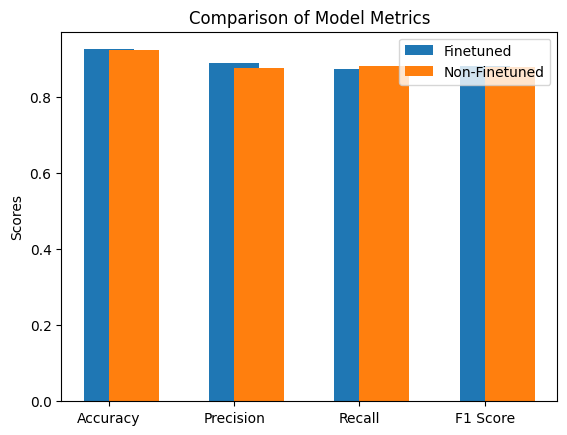

In [50]:
metrics_finetuned = [accuracy_Bert_finetuned, precision_Bert_finetuned, recall_Bert_finetuned, f1_Bert_finetuned]
metrics_non_finetuned = [accuracy_Bert_finetuned_non, precision_Bert_finetuned_non, recall_Bert_finetuned_non, f1_Bert_finetuned_non]
labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

x = range(len(labels))
plt.bar(x, metrics_finetuned, width=0.4, label='Finetuned', align='center')
plt.bar(x, metrics_non_finetuned, width=0.4, label='Non-Finetuned', align='edge')
plt.xticks(x, labels)
plt.ylabel('Scores')
plt.title('Comparison of Model Metrics')
plt.legend()
plt.show()


### Modified Structure (for base BERT model only)

In [57]:
from transformers import BertConfig, BertForSequenceClassification

# Define parameter ranges
num_hidden_layers_options = [6, 12, 18]
num_attention_heads_options = [8, 12, 16]
hidden_sizes = [576, 768, 960]
intermediate_sizes = [2048, 3072, 4096]

best_accuracy = 0
best_config = {}

for num_layers in num_hidden_layers_options:
    for num_heads in num_attention_heads_options:
        for hidden_sz in hidden_sizes:
            for intermediate_sz in intermediate_sizes:
                for act_fn in ["gelu", "relu"]:
                    # Configure the BERT model
                    config = BertConfig.from_pretrained(
                        'bert-base-uncased',
                        num_labels=len(set(y_train_Bert)),
                        num_hidden_layers=num_layers,
                        num_attention_heads=num_heads,
                        hidden_size=hidden_sz,
                        intermediate_size=intermediate_sz,
                        hidden_act=act_fn
                    )
                    model = BertForSequenceClassification(config)
                        
                    # Train the model and get accuracy
                    # Ensure you have a function to train the model and return accuracy
                    accuracy, _, _, _, _ = train_Bert_model_noProgress(model, train_dataset_Bert, test_dataset_Bert)
                    config = {
                            "num_layers": num_layers,
                            "num_heads": num_heads,
                            "hidden_sz": hidden_sz,
                            "intermediate_sz": intermediate_sz,
                            "act_fn": act_fn,
                        }
                    print(f"New Best Accuracy: {accuracy}")
                    print("New Best Configuration:", config)
                    # Update best accuracy and configuration if current is better
                    if accuracy > best_accuracy:
                        best_accuracy = accuracy
                        best_config = {
                            "num_layers": num_layers,
                            "num_heads": num_heads,
                            "hidden_sz": hidden_sz,
                            "intermediate_sz": intermediate_sz,
                            "act_fn": act_fn,
                        }

# Print out the best configuration after all iterations
print(f"Final Best Accuracy: {best_accuracy}")
print("Final Best Configuration:", best_config)


New Best Accuracy: 0.8875
New Best Configuration: {'num_layers': 6, 'num_heads': 8, 'hidden_sz': 576, 'intermediate_sz': 2048, 'act_fn': 'gelu'}
New Best Accuracy: 0.889
New Best Configuration: {'num_layers': 6, 'num_heads': 8, 'hidden_sz': 576, 'intermediate_sz': 2048, 'act_fn': 'relu'}
New Best Accuracy: 0.8945
New Best Configuration: {'num_layers': 6, 'num_heads': 8, 'hidden_sz': 576, 'intermediate_sz': 3072, 'act_fn': 'gelu'}
New Best Accuracy: 0.888
New Best Configuration: {'num_layers': 6, 'num_heads': 8, 'hidden_sz': 576, 'intermediate_sz': 3072, 'act_fn': 'relu'}
New Best Accuracy: 0.888
New Best Configuration: {'num_layers': 6, 'num_heads': 8, 'hidden_sz': 576, 'intermediate_sz': 4096, 'act_fn': 'gelu'}
New Best Accuracy: 0.886
New Best Configuration: {'num_layers': 6, 'num_heads': 8, 'hidden_sz': 576, 'intermediate_sz': 4096, 'act_fn': 'relu'}
New Best Accuracy: 0.883
New Best Configuration: {'num_layers': 6, 'num_heads': 8, 'hidden_sz': 768, 'intermediate_sz': 2048, 'act_fn'

d:\MachineLearning\python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


New Best Accuracy: 0.3475
New Best Configuration: {'num_layers': 18, 'num_heads': 8, 'hidden_sz': 768, 'intermediate_sz': 4096, 'act_fn': 'gelu'}


d:\MachineLearning\python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


New Best Accuracy: 0.3475
New Best Configuration: {'num_layers': 18, 'num_heads': 8, 'hidden_sz': 768, 'intermediate_sz': 4096, 'act_fn': 'relu'}
New Best Accuracy: 0.8805
New Best Configuration: {'num_layers': 18, 'num_heads': 8, 'hidden_sz': 960, 'intermediate_sz': 2048, 'act_fn': 'gelu'}
New Best Accuracy: 0.888
New Best Configuration: {'num_layers': 18, 'num_heads': 8, 'hidden_sz': 960, 'intermediate_sz': 2048, 'act_fn': 'relu'}
New Best Accuracy: 0.876
New Best Configuration: {'num_layers': 18, 'num_heads': 8, 'hidden_sz': 960, 'intermediate_sz': 3072, 'act_fn': 'gelu'}
New Best Accuracy: 0.8905
New Best Configuration: {'num_layers': 18, 'num_heads': 8, 'hidden_sz': 960, 'intermediate_sz': 3072, 'act_fn': 'relu'}


d:\MachineLearning\python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


New Best Accuracy: 0.3475
New Best Configuration: {'num_layers': 18, 'num_heads': 8, 'hidden_sz': 960, 'intermediate_sz': 4096, 'act_fn': 'gelu'}


d:\MachineLearning\python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


New Best Accuracy: 0.2905
New Best Configuration: {'num_layers': 18, 'num_heads': 8, 'hidden_sz': 960, 'intermediate_sz': 4096, 'act_fn': 'relu'}
New Best Accuracy: 0.8795
New Best Configuration: {'num_layers': 18, 'num_heads': 12, 'hidden_sz': 576, 'intermediate_sz': 2048, 'act_fn': 'gelu'}
New Best Accuracy: 0.891
New Best Configuration: {'num_layers': 18, 'num_heads': 12, 'hidden_sz': 576, 'intermediate_sz': 2048, 'act_fn': 'relu'}
New Best Accuracy: 0.8885
New Best Configuration: {'num_layers': 18, 'num_heads': 12, 'hidden_sz': 576, 'intermediate_sz': 3072, 'act_fn': 'gelu'}
New Best Accuracy: 0.898
New Best Configuration: {'num_layers': 18, 'num_heads': 12, 'hidden_sz': 576, 'intermediate_sz': 3072, 'act_fn': 'relu'}
New Best Accuracy: 0.9
New Best Configuration: {'num_layers': 18, 'num_heads': 12, 'hidden_sz': 576, 'intermediate_sz': 4096, 'act_fn': 'gelu'}
New Best Accuracy: 0.8475
New Best Configuration: {'num_layers': 18, 'num_heads': 12, 'hidden_sz': 576, 'intermediate_sz': 4

d:\MachineLearning\python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


New Best Accuracy: 0.2905
New Best Configuration: {'num_layers': 18, 'num_heads': 12, 'hidden_sz': 768, 'intermediate_sz': 4096, 'act_fn': 'relu'}
New Best Accuracy: 0.8835
New Best Configuration: {'num_layers': 18, 'num_heads': 12, 'hidden_sz': 960, 'intermediate_sz': 2048, 'act_fn': 'gelu'}
New Best Accuracy: 0.8895
New Best Configuration: {'num_layers': 18, 'num_heads': 12, 'hidden_sz': 960, 'intermediate_sz': 2048, 'act_fn': 'relu'}
New Best Accuracy: 0.8895
New Best Configuration: {'num_layers': 18, 'num_heads': 12, 'hidden_sz': 960, 'intermediate_sz': 3072, 'act_fn': 'gelu'}


d:\MachineLearning\python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


New Best Accuracy: 0.808
New Best Configuration: {'num_layers': 18, 'num_heads': 12, 'hidden_sz': 960, 'intermediate_sz': 3072, 'act_fn': 'relu'}


d:\MachineLearning\python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


New Best Accuracy: 0.3475
New Best Configuration: {'num_layers': 18, 'num_heads': 12, 'hidden_sz': 960, 'intermediate_sz': 4096, 'act_fn': 'gelu'}


d:\MachineLearning\python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


New Best Accuracy: 0.2905
New Best Configuration: {'num_layers': 18, 'num_heads': 12, 'hidden_sz': 960, 'intermediate_sz': 4096, 'act_fn': 'relu'}
New Best Accuracy: 0.8875
New Best Configuration: {'num_layers': 18, 'num_heads': 16, 'hidden_sz': 576, 'intermediate_sz': 2048, 'act_fn': 'gelu'}
New Best Accuracy: 0.887
New Best Configuration: {'num_layers': 18, 'num_heads': 16, 'hidden_sz': 576, 'intermediate_sz': 2048, 'act_fn': 'relu'}
New Best Accuracy: 0.8935
New Best Configuration: {'num_layers': 18, 'num_heads': 16, 'hidden_sz': 576, 'intermediate_sz': 3072, 'act_fn': 'gelu'}
New Best Accuracy: 0.8795
New Best Configuration: {'num_layers': 18, 'num_heads': 16, 'hidden_sz': 576, 'intermediate_sz': 3072, 'act_fn': 'relu'}
New Best Accuracy: 0.8795
New Best Configuration: {'num_layers': 18, 'num_heads': 16, 'hidden_sz': 576, 'intermediate_sz': 4096, 'act_fn': 'gelu'}


d:\MachineLearning\python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


New Best Accuracy: 0.789
New Best Configuration: {'num_layers': 18, 'num_heads': 16, 'hidden_sz': 576, 'intermediate_sz': 4096, 'act_fn': 'relu'}
New Best Accuracy: 0.8935
New Best Configuration: {'num_layers': 18, 'num_heads': 16, 'hidden_sz': 768, 'intermediate_sz': 2048, 'act_fn': 'gelu'}
New Best Accuracy: 0.882
New Best Configuration: {'num_layers': 18, 'num_heads': 16, 'hidden_sz': 768, 'intermediate_sz': 2048, 'act_fn': 'relu'}
New Best Accuracy: 0.8855
New Best Configuration: {'num_layers': 18, 'num_heads': 16, 'hidden_sz': 768, 'intermediate_sz': 3072, 'act_fn': 'gelu'}
New Best Accuracy: 0.8715
New Best Configuration: {'num_layers': 18, 'num_heads': 16, 'hidden_sz': 768, 'intermediate_sz': 3072, 'act_fn': 'relu'}
New Best Accuracy: 0.8615
New Best Configuration: {'num_layers': 18, 'num_heads': 16, 'hidden_sz': 768, 'intermediate_sz': 4096, 'act_fn': 'gelu'}


d:\MachineLearning\python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


New Best Accuracy: 0.7545
New Best Configuration: {'num_layers': 18, 'num_heads': 16, 'hidden_sz': 768, 'intermediate_sz': 4096, 'act_fn': 'relu'}
New Best Accuracy: 0.881
New Best Configuration: {'num_layers': 18, 'num_heads': 16, 'hidden_sz': 960, 'intermediate_sz': 2048, 'act_fn': 'gelu'}
New Best Accuracy: 0.895
New Best Configuration: {'num_layers': 18, 'num_heads': 16, 'hidden_sz': 960, 'intermediate_sz': 2048, 'act_fn': 'relu'}
New Best Accuracy: 0.8875
New Best Configuration: {'num_layers': 18, 'num_heads': 16, 'hidden_sz': 960, 'intermediate_sz': 3072, 'act_fn': 'gelu'}
New Best Accuracy: 0.844
New Best Configuration: {'num_layers': 18, 'num_heads': 16, 'hidden_sz': 960, 'intermediate_sz': 3072, 'act_fn': 'relu'}


d:\MachineLearning\python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


New Best Accuracy: 0.2905
New Best Configuration: {'num_layers': 18, 'num_heads': 16, 'hidden_sz': 960, 'intermediate_sz': 4096, 'act_fn': 'gelu'}
New Best Accuracy: 0.2905
New Best Configuration: {'num_layers': 18, 'num_heads': 16, 'hidden_sz': 960, 'intermediate_sz': 4096, 'act_fn': 'relu'}
Final Best Accuracy: 0.9035
Final Best Configuration: {'num_layers': 18, 'num_heads': 8, 'hidden_sz': 768, 'intermediate_sz': 3072, 'act_fn': 'gelu'}


d:\MachineLearning\python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## 3.2 Examine the attention matrix

In [58]:
correctList = []
incorrectList = []

# Ensure test_labels is a list or convert it to a list
test_labels_list = list(y_test_Bert)

for i in range(len(test_labels_list)):
    if test_labels_list[i] == predictions_Bert_finetuned[i]:
        if len(correctList) < 20:
            correctList.append(X_test_Bert[i])
    else:
        if len(incorrectList) < 12:
            incorrectList.append(X_test_Bert[i])

    if len(correctList) >= 20 and len(incorrectList) >= 12:
        break


rotten so im not very ambitious right now
blog because i feel shitty
her separate from me because i don t ever want her to feel
my bouquet of red and yellow tulips under my arm feeling slightly more
a little vain when i did this one
into a shop anywhere where i do not feel uncomfortable
when at the end of a telephone call
i clung to a relationship with a boy who was in many ways
feel particularly agitated
the feeling of loss will ever go away but it may dull to
i completely hated things i d exercise my democratic right speak my mind
handed however i play billiards left handed naturally so me trying to play
dropped a frog down my neck
this blog but sometimes i feel for my faithful readers
with myself that i did not foresee her frustrations earlier leading to the
he generous


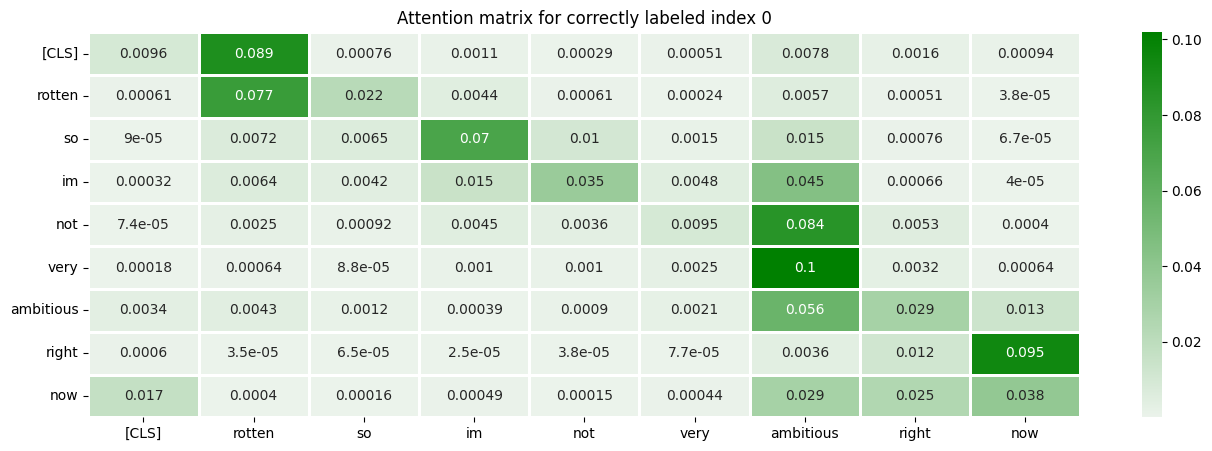

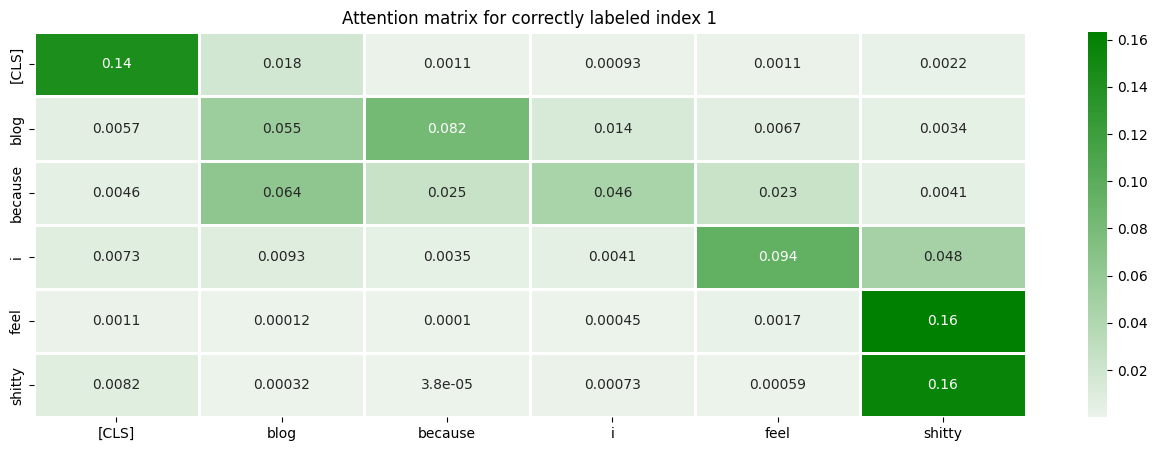

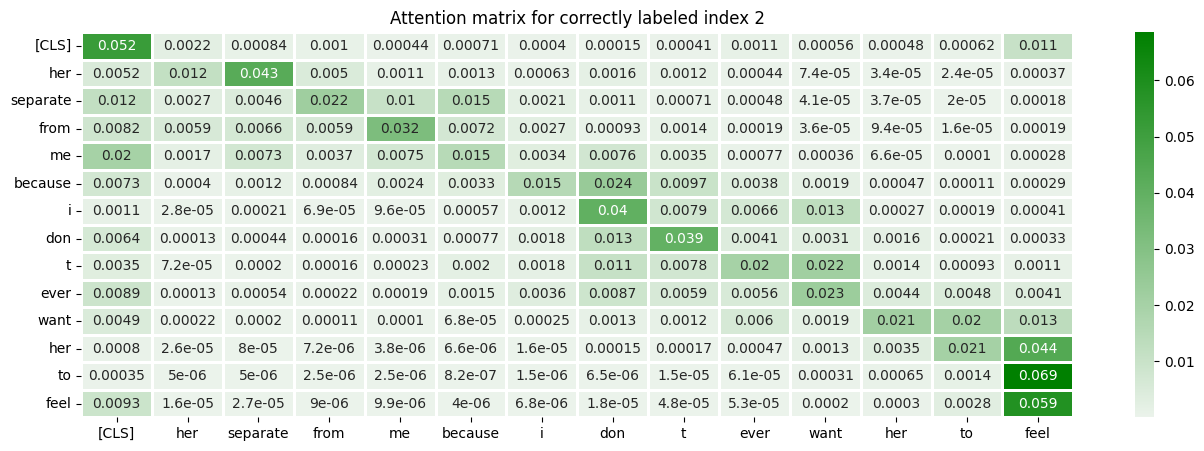

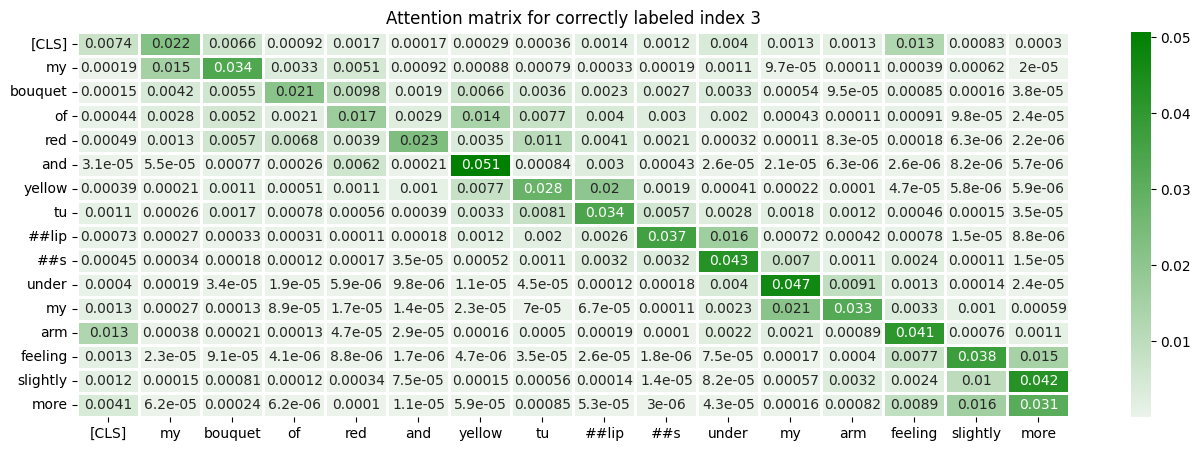

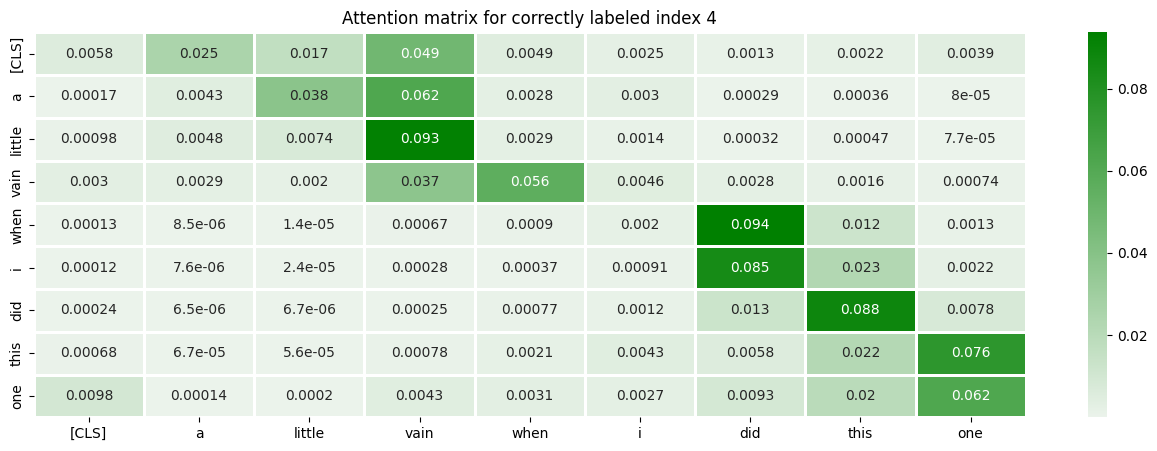

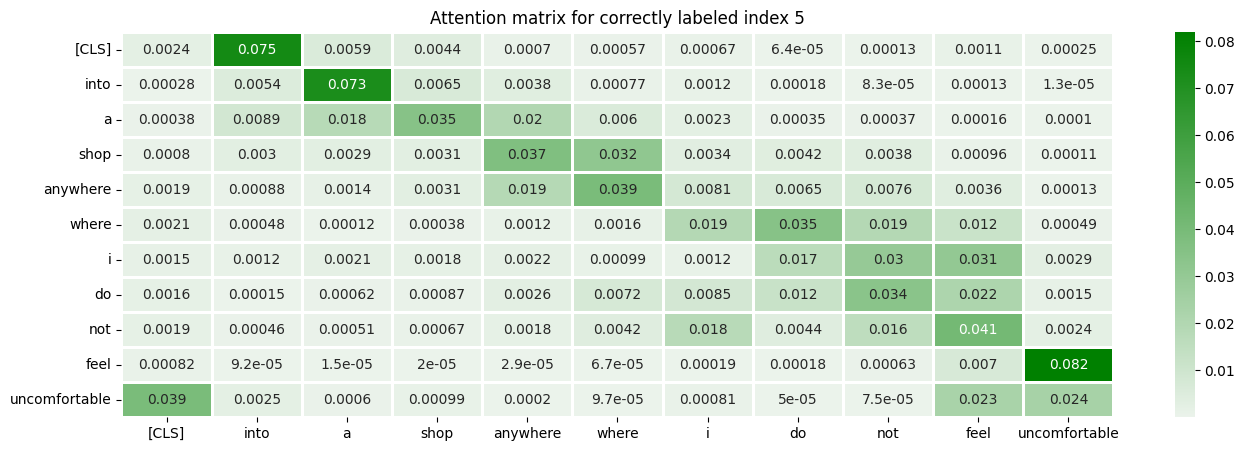

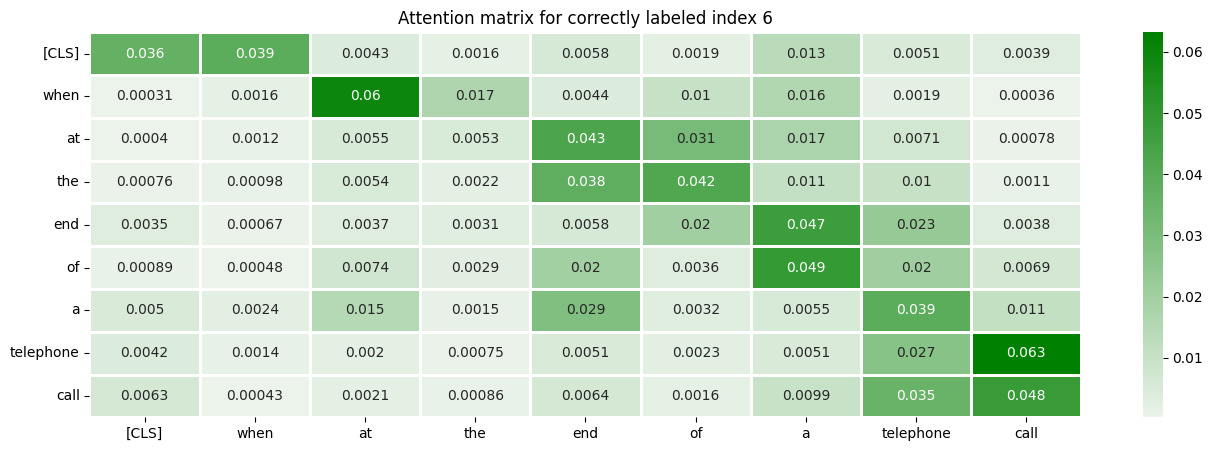

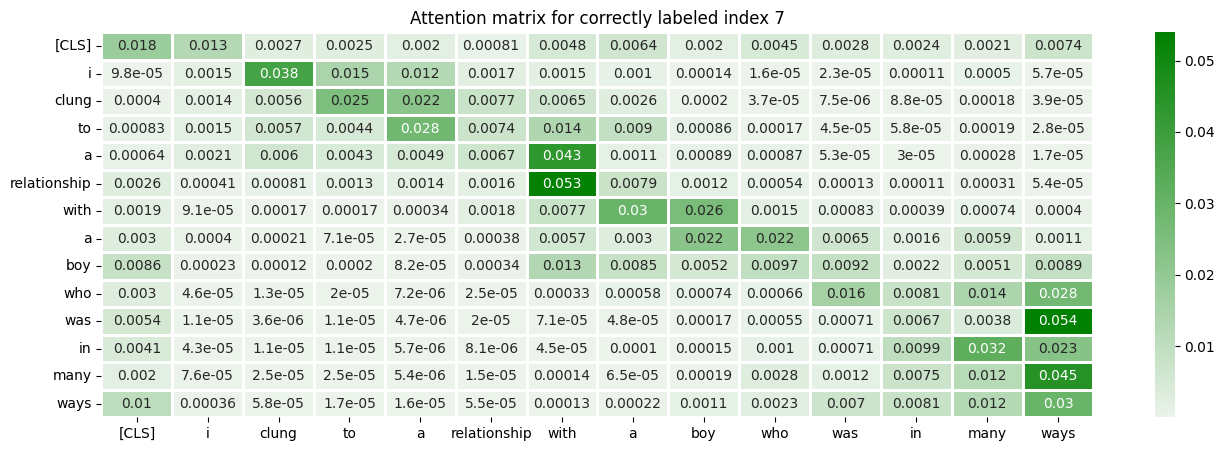

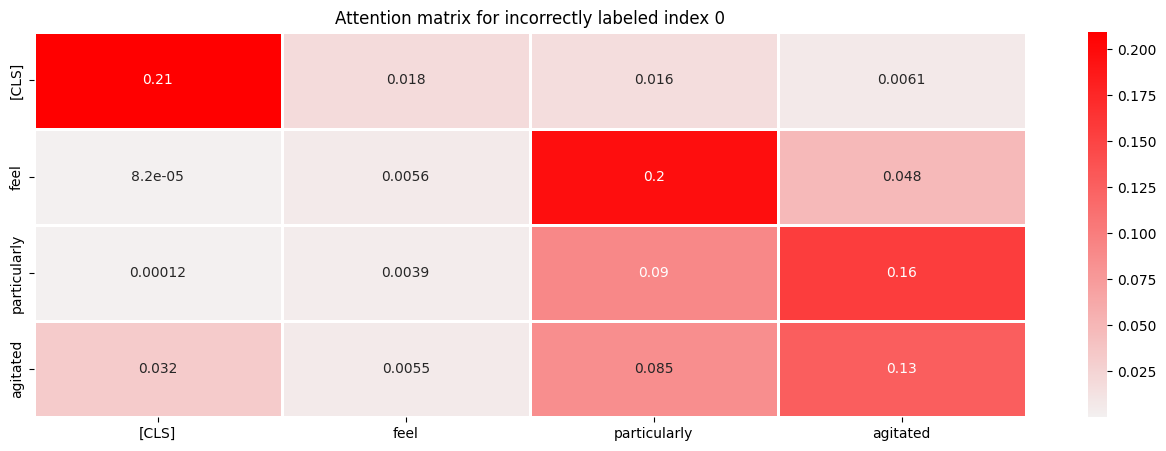

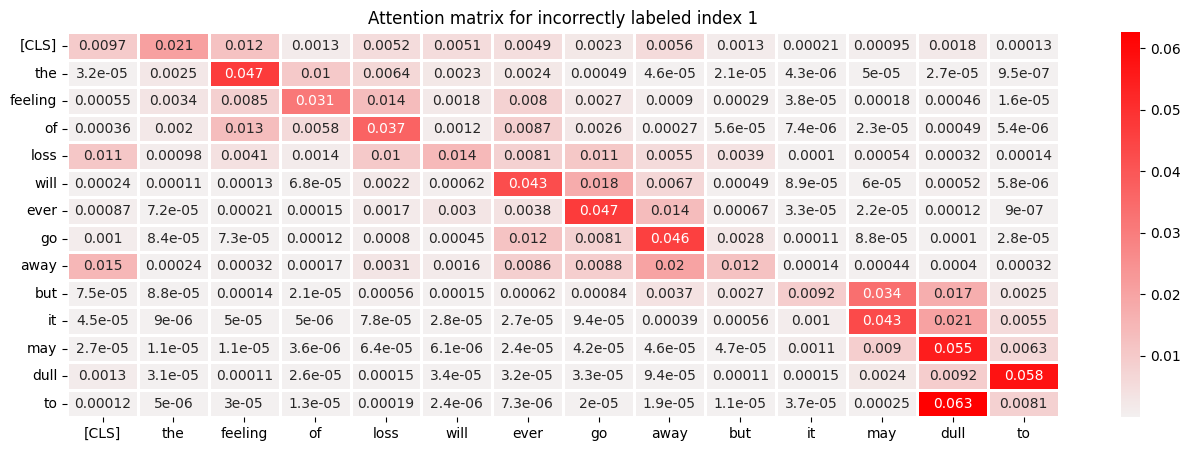

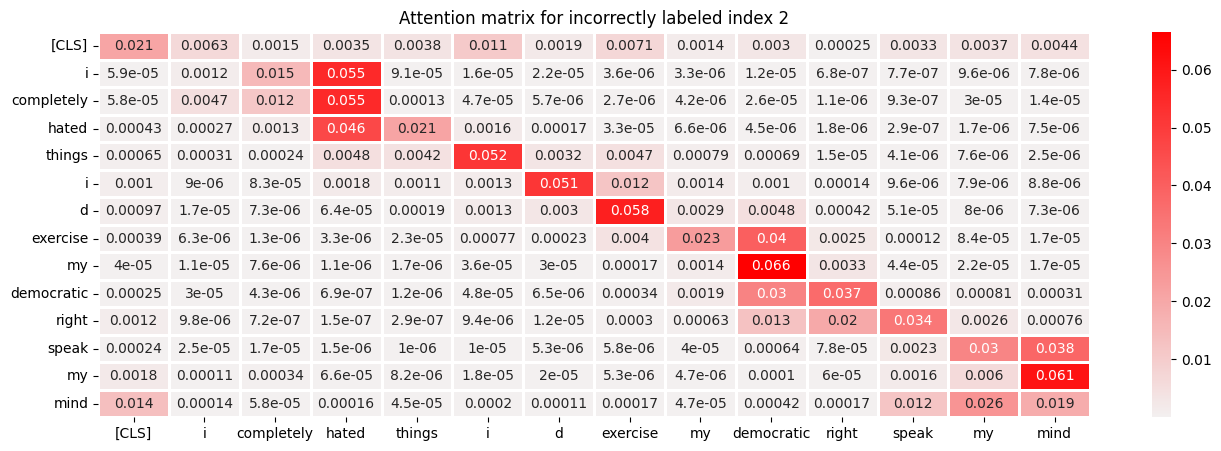

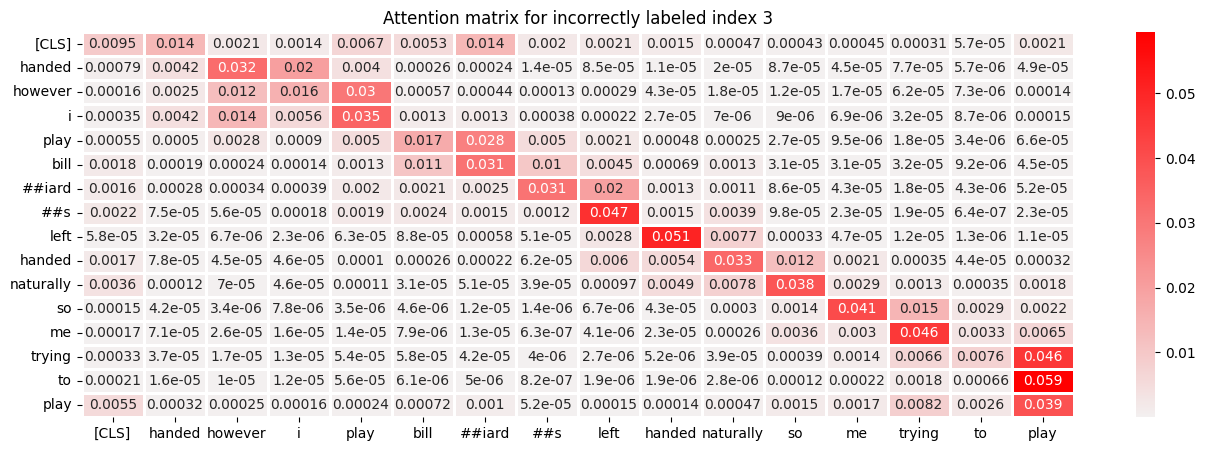

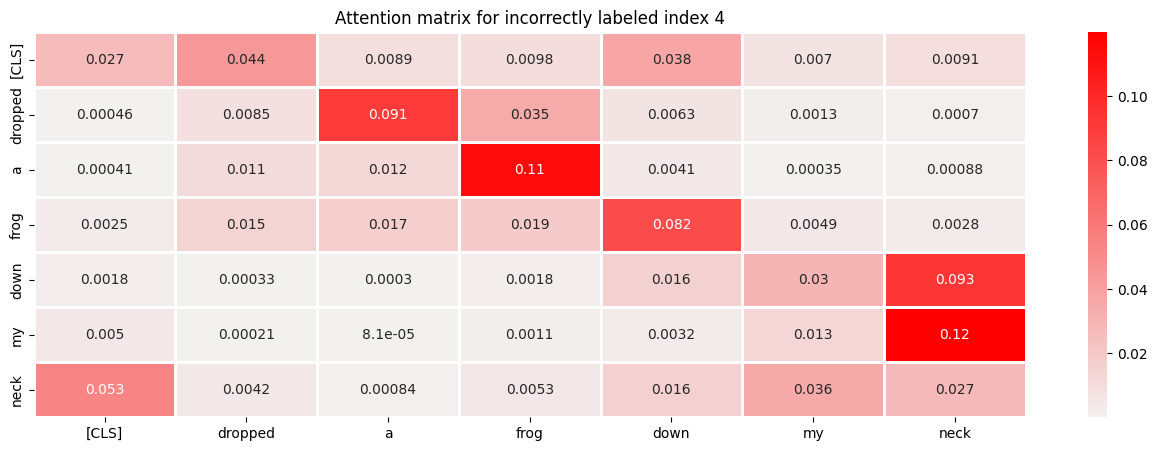

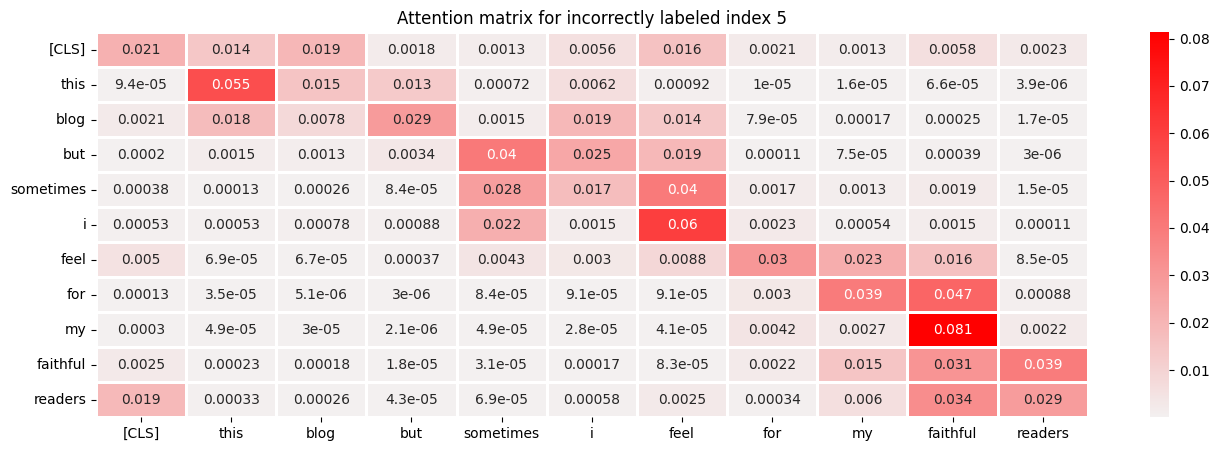

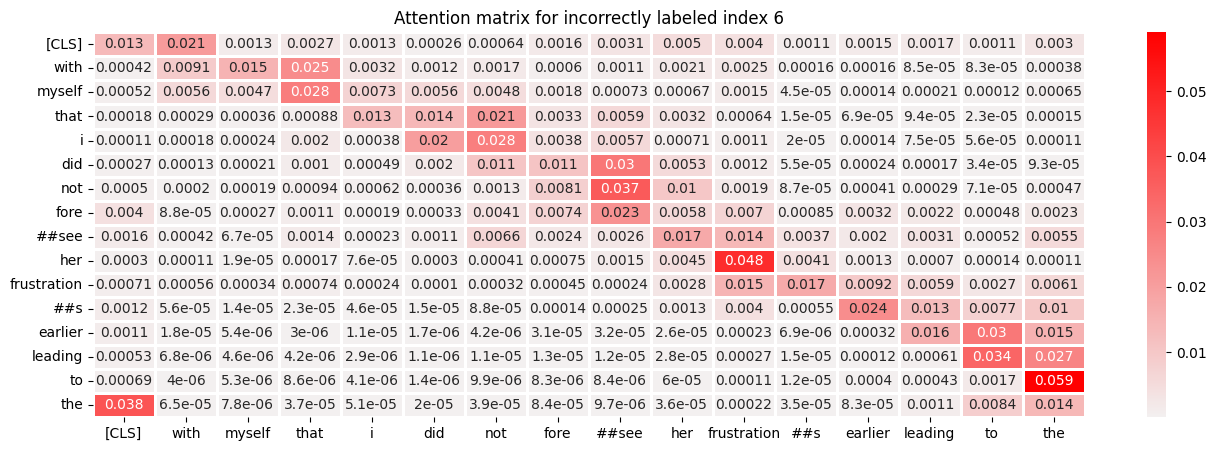

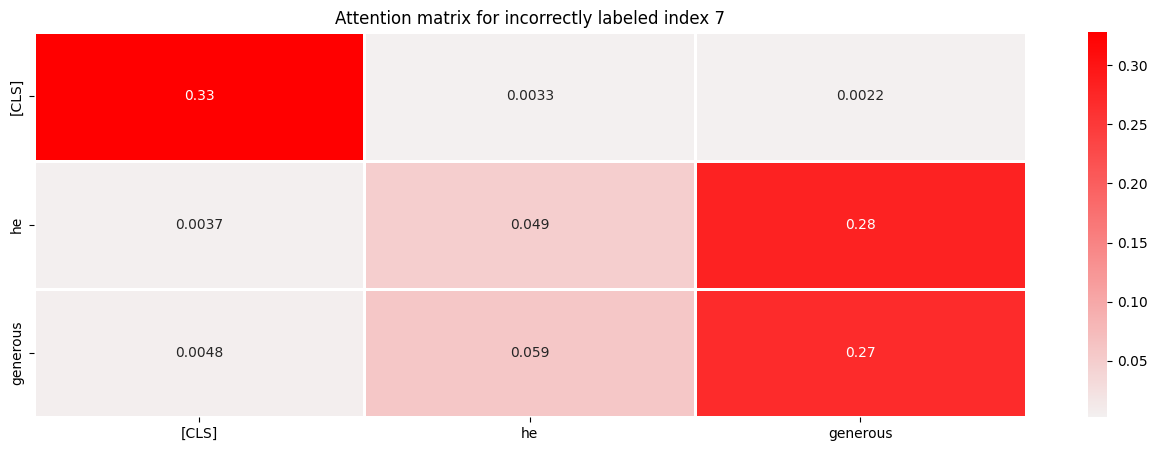

In [59]:
def split_sentence(sentence):
    sentence = sentence.translate(str.maketrans('', '', string.punctuation))
    words = sentence.split()
    ans = " ".join(words[3:16])
    return ans

def get_layer(layer, attention, shape):
  attention = attention[layer][0][layer].detach()/shape
  return attention

#chosen layer to generate attention matrix
layer = 6
def createAttentionMatrix(review, layer, color, index, correct=True):
    review = split_sentence(review)
    print(review)
    tk = [['[CLS]'] + tokenizer.tokenize(t)[:768] for t in [review]]
    tks = torch.tensor([tokenizer.convert_tokens_to_ids(tokens) for tokens in tk], dtype=torch.int)
    tks = torch.nn.utils.rnn.pad_sequence(tks, batch_first=True, padding_value=0)

    # Enable the output of attention weights
    model_output = model_Bert.cpu()(tks, output_attentions=True)
    attentionOutput = model_output.attentions

    att = get_layer(layer, attentionOutput, tks.shape[1])
    plt.figure(figsize=(16,5))
    heat = sns.heatmap(att, annot=True, cmap=sns.light_palette(color, as_cmap=True), linewidths=1, xticklabels=tk[0], yticklabels=tk[0])
    if correct:
        heat.set_title('Attention matrix for correctly labeled index ' + index)
    else:
        heat.set_title('Attention matrix for incorrectly labeled index ' + index)

# Visualization of Attention Matrices
for i, text in enumerate(correctList[:8]):
    createAttentionMatrix(text, layer, 'green', str(i), correct=True)


for i, text in enumerate(incorrectList[:8]):
    createAttentionMatrix(text, layer, 'red', str(i), correct=False)